共 450 篇文章
重复 133 篇文章
共提取 317 篇去重后的文章
文章 1 K1: 低空经济;543框架;资源勘探;协同感知;新质生产力;矿产勘查工程
文章 1 AB: [研究目的]本文基于《中国2024年低空经济场景白皮书》提出的“543框架”理论，系统探讨地勘行业融入低空经济的发展路径与战略定位。研究旨在揭示地勘行业在低空经济领域的独特优势以及面临的机遇和挑战，明...
--------------------------------------------------------------------------------
文章 2 K1: 低空经济;新质生产力;战略新兴产业;发展逻辑
文章 2 AB: 作为战略性新兴产业,低空经济在政策支持、市场需求、技术创新等多重因素推动下,逐渐发展成为经济高质量增长的新引擎。低空经济的发展具有理论、历史和实践三重内在逻辑。低空经济对社会各领域产生深远影响:一方面...
--------------------------------------------------------------------------------
文章 3 K1: 低空经济;国家安全;风险识别;风险成因;风险治理
文章 3 AB: 低空经济作为我国经济驱动的新引擎，代表了新质生产力的发展要求，但其发展中存在一些威胁国家安全的风险，已不容忽视。当前，我国低空经济发展在产业、财政和市场等经济领域面临挑战，在低空资源的开发、利用、分配...
--------------------------------------------------------------------------------
文章 4 K1: 低空飞行;低空经济;低空数据框架;数据基础设施
文章 4 AB: 低空经济作为新兴产业展现出非凡的潜力和重要性。本文系统梳理我国低空基础设施的发展历程与阶段性成效，深入分析当前低空飞行基础设施建设中存在的问题。在此基础上，构建包含资源汇集、平台建设、标准体系和安全保...
--------------------------------------------------------------------------------
共 450 篇文章
重复 133 篇文章
共提取 317 篇去重后的文章
文档数量: 31

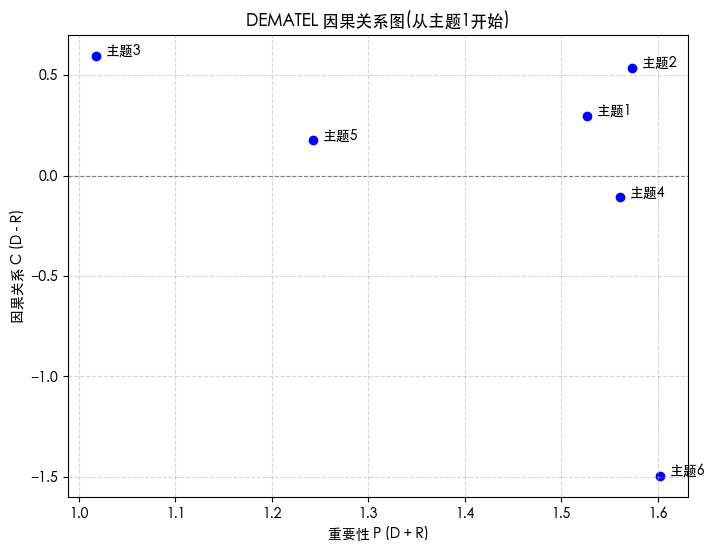


=== DEMATEL 分析结果总结（从主题1开始） ===
• 主题2 在总影响矩阵中具有最高的影响力（D 值较大），说明它们是主要驱动因素。
• 主题6 的受影响程度（R 值）显著高于其他主题，属于典型的结果型因素。
• 因果关系图显示，主题1, 主题2 落在右上象限，既具有重要性（P 高），又对其他主题具有明显驱动作用（C > 0）。
• 对比原始矩阵与归一化矩阵分析结果，可以看出，归一化后主题间关系更均衡，避免了高频主题对结果的过度支配，更能体现主题间的相对因果关系。

最终，可以得出结论：
1. 因子识别：明确哪些主题是关键因子（高 C 高 P），哪些是结果因子（低 C 高 P）。
2. 管理启示：建议在研究/应用中优先关注关键因子，因为它们会驱动其他主题的发展。


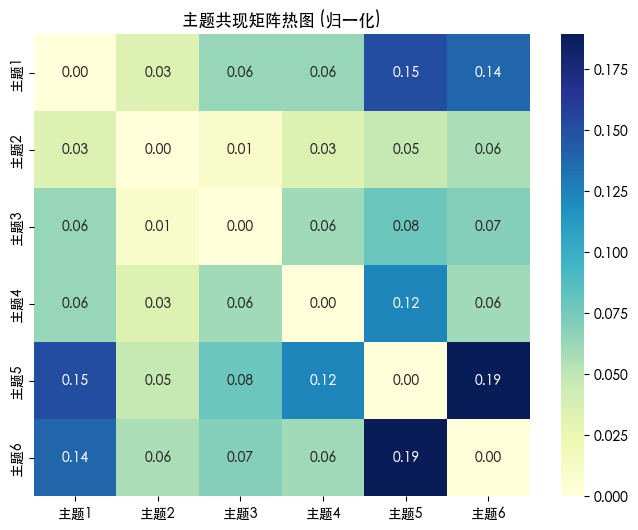

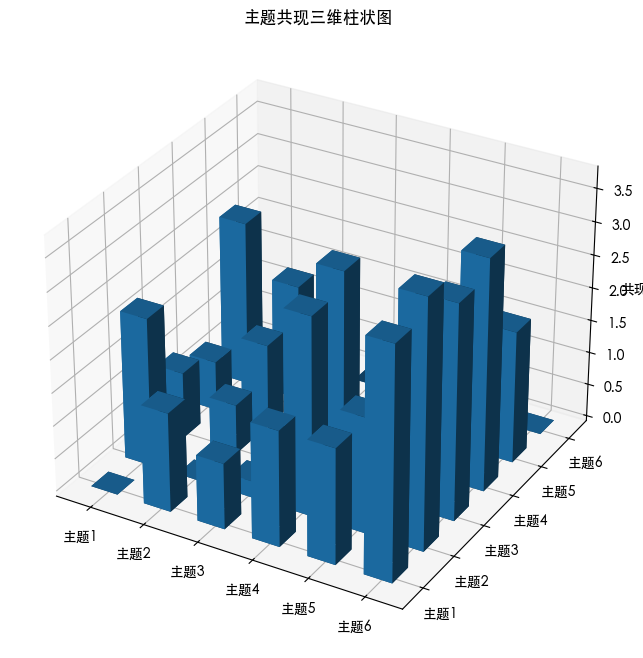

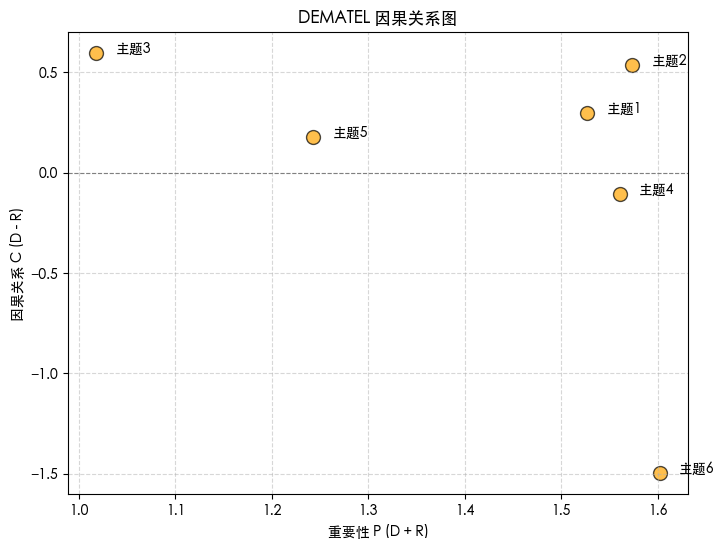

✅ 已导出结果到 分析结果.xlsx


In [5]:
import jieba
import jieba.posseg as pseg
from gensim import corpora, models
import pandas as pd
from collections import defaultdict
import re
import numpy as np
from gensim.models.coherencemodel import CoherenceModel
import itertools
import re
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


class ChineseLDA:
    def __init__(self, stop_words_file=None):
        """
        初始化中文LDA模型
        """
        self.stop_words = self.load_stop_words(stop_words_file)
        self.dictionary = None
        self.corpus = None
        self.lda_model = None
        self.processed_docs = None
 
        
    def load_stop_words(self, file_path):
        """加载停用词表"""
        if file_path:
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    return set([line.strip() for line in f])
            except FileNotFoundError:
                print(f"停用词文件 {file_path} 未找到，使用默认停用词")
        
        # 默认停用词
        return set(['的', '了', '在', '是', '我', '有', '和', '就', 
                   '不', '人', '都', '一', '一个', '上', '也', '很', 
                   '到', '说', '要', '去', '你', '会', '着', '没有',
                   '看', '好', '自己', '这', '那', '他', '她', '它'])
    
    def preprocess_text(self, text):
        """
        文本预处理
        """
        # 去除特殊字符和标点
        text = re.sub(r'[^\u4e00-\u9fa5]', ' ', text)
        
        # 使用jieba进行分词
        words = jieba.cut(text)
        
        # 过滤停用词和单字词
        filtered_words = []
        for word in words:
            word = word.strip()
            if (len(word) > 1 and 
                word not in self.stop_words and 
                not word.isspace()):
                filtered_words.append(word)
                
        return filtered_words
    
    def prepare_corpus(self, documents):
        """
        准备语料库
        """
        print("正在进行文本预处理...")
        self.processed_docs = [self.preprocess_text(doc) for doc in documents]
        
        # 统计词频，过滤低频词
        frequency = defaultdict(int)
        for text in self.processed_docs:
            for token in text:
                frequency[token] += 1
        
        # 只保留出现次数大于1的词
        self.processed_docs = [[token for token in text if frequency[token] > 1] 
                         for text in self.processed_docs]
        
        # 创建词典和语料库
        self.dictionary = corpora.Dictionary(self.processed_docs)
        # 过滤极端值
        self.dictionary.filter_extremes(no_below=2, no_above=0.8)
        self.corpus = [self.dictionary.doc2bow(text) for text in self.processed_docs]
        
        print(f"词典大小: {len(self.dictionary)}")
        print(f"语料库文档数: {len(self.corpus)}")
        
        return self.processed_docs
    
    def train_lda(self, documents, num_topics=5, passes=10, random_state=42):
        """
        训练LDA模型
        """
        processed_docs = self.prepare_corpus(documents)
        
        print(f"训练LDA模型，主题数: {num_topics}")
        self.lda_model = models.LdaModel(
            corpus=self.corpus,
            id2word=self.dictionary,
            num_topics=num_topics,
            random_state=random_state,
            passes=passes,
            alpha='auto',
            per_word_topics=True
        )
        
        return self.lda_model
    
    def print_topics(self, num_words):
        """打印每个主题的关键词及主题权重"""
        if self.lda_model is None:
            print("请先训练模型")
            return

        # 计算每个主题在整个语料库中的平均权重
        topic_weights = np.zeros(self.lda_model.num_topics)
        for bow in self.corpus:
            doc_topics = self.lda_model.get_document_topics(bow)
            for topic_id, prob in doc_topics:
                topic_weights[topic_id] += prob
        topic_weights /= len(self.corpus)
        # 主题权重归一化处理
        # topic_weights = topic_weights / topic_weights.sum()

        print("\n=== 主题关键词 ===")
        for topic_id in range(self.lda_model.num_topics):
            topic_words = self.lda_model.show_topic(topic_id, num_words)
            words_str = " + ".join([f"{prob:.3f}*{word}" for word, prob in topic_words])
            print(f"主题 {topic_id} (权重: {topic_weights[topic_id]:.3f}): {words_str}")
            print("-" * 80)
    
    def get_document_topics(self, documents, num_docs=5):
        """获取文档的主题分布"""
        if self.lda_model is None:
            print("请先训练模型")
            return
        
        print(f"\n=== 前{num_docs}个文档的主题分布 ===")
        for i, doc in enumerate(documents[:num_docs]):
            bow = self.dictionary.doc2bow(self.preprocess_text(doc))
            topics = self.lda_model.get_document_topics(bow)
            
            print(f"\n文档 {i+1}: {doc[:50]}...")
            top_topics = sorted(topics, key=lambda x: x[1], reverse=True)[:3]
            for topic_id, prob in top_topics:
                print(f"  主题 {topic_id}: {prob:.3f}")
    
    def calculate_perplexity(self):
        """计算困惑度"""
        if self.lda_model is None:
            print("请先训练模型")
            return None
        
        perplexity = self.lda_model.log_perplexity(self.corpus)
        return perplexity
    
    def calculate_coherence(self, coherence_type='c_v'):
        """
        计算主题一致性分数
        coherence_type: 'u_mass', 'c_v', 'c_uci', 'c_npmi'
        """
        if self.lda_model is None or self.processed_docs is None:
            print("请先训练模型")
            return None
        
        try:
            coherence_model = CoherenceModel(
                model=self.lda_model,
                texts=self.processed_docs,
                dictionary=self.dictionary,
                coherence=coherence_type
            )
            coherence_score = coherence_model.get_coherence()
            return coherence_score
        except Exception as e:
            print(f"计算一致性时出错: {e}")
            return None
    
    def calculate_topic_similarity(self, num_top_words=10):
        """
        计算主题间相似度
        基于主题关键词的Jaccard相似度
        """
        if self.lda_model is None:
            print("请先训练模型")
            return None
        
        # 获取每个主题的关键词
        topic_words = []
        for topic_id in range(self.lda_model.num_topics):
            words = [word for word, prob in self.lda_model.show_topic(topic_id, num_top_words)]
            topic_words.append(set(words))
        
        # 计算主题间相似度矩阵
        similarity_matrix = np.zeros((self.lda_model.num_topics, self.lda_model.num_topics))
        
        for i in range(self.lda_model.num_topics):
            for j in range(self.lda_model.num_topics):
                if i == j:
                    similarity_matrix[i][j] = 1.0
                else:
                    # Jaccard相似度
                    intersection = len(topic_words[i] & topic_words[j])
                    union = len(topic_words[i] | topic_words[j])
                    similarity_matrix[i][j] = intersection / union if union > 0 else 0
        
        return similarity_matrix
    
    def calculate_topic_diversity(self, num_top_words=10):
        """
        计算主题多样性
        衡量不同主题间关键词的重叠程度
        """
        if self.lda_model is None:
            print("请先训练模型")
            return None
        
        all_words = set()
        unique_words_per_topic = []
        
        for topic_id in range(self.lda_model.num_topics):
            words = [word for word, prob in self.lda_model.show_topic(topic_id, num_top_words)]
            word_set = set(words)
            all_words.update(word_set)
            unique_words_per_topic.append(word_set)
        
        # 计算平均主题独特性
        total_unique = 0
        for i, topic_words in enumerate(unique_words_per_topic):
            other_words = set()
            for j, other_topic_words in enumerate(unique_words_per_topic):
                if i != j:
                    other_words.update(other_topic_words)
            
            unique_to_topic = topic_words - other_words
            total_unique += len(unique_to_topic) / len(topic_words)
        
        diversity_score = total_unique / self.lda_model.num_topics
        return diversity_score
    
    def evaluate_model(self, comprehensive=True):
        """评估模型"""
        if self.lda_model is None:
            print("请先训练模型")
            return
        
        print("\n" + "=" * 60)
        print("模型评估结果")
        print("=" * 60)
        
        # 1. 困惑度评估
        perplexity = self.calculate_perplexity()
        print(f"📊 模型困惑度: {perplexity:.3f}")
        print("   (值越小越好，表示模型对数据的拟合越好)")
        
        if comprehensive:
            # 2. 主题一致性评估
            print("\n📈 主题一致性分数:")
            coherence_types = ['c_v', 'c_npmi', 'u_mass']
            for coh_type in coherence_types:
                try:
                    coherence_score = self.calculate_coherence(coh_type)
                    if coherence_score is not None:
                        print(f"   {coh_type}: {coherence_score:.4f}")
                except Exception as e:
                    print(f"   {coh_type}: 计算失败 - {e}")
            
            print("   (c_v, c_npmi: 值越大越好; u_mass: 值越接近0越好)")
            
            # 3. 主题相似度分析
            print("\n🔄 主题间相似度分析:")
            similarity_matrix = self.calculate_topic_similarity()
            if similarity_matrix is not None:
                print("   主题相似度矩阵 (Jaccard相似度):")
                for i in range(len(similarity_matrix)):
                    row_str = "   "
                    for j in range(len(similarity_matrix[i])):
                        if i == j:
                            row_str += " -    "
                        else:
                            row_str += f"{similarity_matrix[i][j]:.3f} "
                    print(row_str)
                
                # 计算平均主题相似度（排除对角线）
                mask = ~np.eye(len(similarity_matrix), dtype=bool)
                avg_similarity = np.mean(similarity_matrix[mask])
                print(f"   平均主题相似度: {avg_similarity:.4f}")
                print("   (值越小越好，表示主题区分度越高)")
            
            # 4. 主题多样性
            diversity = self.calculate_topic_diversity()
            if diversity is not None:
                print(f"\n🎯 主题多样性: {diversity:.4f}")
                print("   (值越大越好，表示主题关键词重叠越少)")
            
            # 5. 主题质量分析
            print("\n🔍 主题质量分析:")
            self.analyze_topic_quality()
    
    def analyze_topic_quality(self, num_words=8):
        """分析主题质量"""
        if self.lda_model is None:
            return
        
        print("   各主题关键词清晰度:")
        for topic_id in range(self.lda_model.num_topics):
            topic_words = self.lda_model.show_topic(topic_id, num_words)
            words = [word for word, prob in topic_words]
            probs = [prob for word, prob in topic_words]
            
            # 计算主题关键词的概率分布熵（越低表示主题越集中）
            entropy = -np.sum([p * np.log(p) for p in probs])
            print(f"   主题 {topic_id}: 熵={entropy:.3f}, 关键词={', '.join(words)}")
        print('''熵高 → 主题分散（没有特别核心的词; 熵低 → 主题集中（少数几个词就能很好地代表这个主题; 熵用来评估一个主题是不是清晰''')
    
    def find_optimal_topics(self, documents, min_topics=2, max_topics=10, step=1):
        """
        寻找最优主题数量
        基于困惑度和一致性分数
        """
        print("正在寻找最优主题数量...")
        
        results = []
        topic_nums = range(min_topics, max_topics + 1, step)
        
        for num_topics in topic_nums:
            print(f"\n测试主题数: {num_topics}")
            
            # 训练模型
            lda_model = ChineseLDA()
            lda_model.train_lda(documents, num_topics=num_topics, passes=10)
            
            # 计算评估指标
            perplexity = lda_model.calculate_perplexity()
            coherence = lda_model.calculate_coherence('c_v')
            
            results.append({
                'num_topics': num_topics,
                'perplexity': perplexity,
                'coherence': coherence
            })
            
            print(f"  困惑度: {perplexity:.3f}")
            print(f"  一致性: {coherence:.4f}")
        
        # 找到最优主题数
        if results:
            # 基于一致性分数选择（通常更可靠）
            best_by_coherence = max(results, key=lambda x: x['coherence'] if x['coherence'] is not None else -1)
            # 基于困惑度选择
            best_by_perplexity = min(results, key=lambda x: x['perplexity'] if x['perplexity'] is not None else float('inf'))
            
            print(f"\n🎯 最优主题数分析:")
            print(f"   基于一致性: {best_by_coherence['num_topics']} 个主题 (一致性: {best_by_coherence['coherence']:.4f})")
            print(f"   基于困惑度: {best_by_perplexity['num_topics']} 个主题 (困惑度: {best_by_perplexity['perplexity']:.3f})")
            
            # 推荐使用一致性分数选择的结果
            recommended_topics = best_by_coherence['num_topics']
            print(f"   💡 推荐使用 {recommended_topics} 个主题")
            
            return recommended_topics, results
        
        return None, []

    def calculate_topic_cooccurrence(self, threshold=0.01):
        """
        计算主题共现矩阵
        threshold: 只有主题概率大于该阈值才算出现
        返回: 共现矩阵 (num_topics x num_topics)
        """
        if self.lda_model is None or self.corpus is None:
            print("请先训练模型")
            return None

        import itertools
        num_topics = self.lda_model.num_topics
        co_matrix = np.zeros((num_topics, num_topics))

        for bow in self.corpus:
            doc_topics = self.lda_model.get_document_topics(bow)
            present_topics = [topic_id for topic_id, prob in doc_topics if prob >= threshold]

            for i, j in itertools.combinations_with_replacement(present_topics, 2):
                co_matrix[i][j] += 1
                if i != j:
                    co_matrix[j][i] += 1

        # 将共现次数归一化为频率
        np.fill_diagonal(co_matrix, 0)           # 将对角线置为0
        co_matrix_raw = co_matrix
        co_matrix_normalized = co_matrix / len(self.corpus)  # 归一化
        return co_matrix_raw, co_matrix_normalized


def dematel_analysis(co_matrix):
    """
    co_matrix: 初始主题共现矩阵（对角线为0，归一化或未归一化）
    labels: 每个因素/主题的名称（可选）
    返回: 标准化矩阵 X_s, 总影响矩阵 T, D, R, C, P
    """
    # 1. 标准化
    row_sum = co_matrix.sum(axis=1)
    col_sum = co_matrix.sum(axis=0)
    s = max(row_sum.max(), col_sum.max())
    X_s = co_matrix / s if s != 0 else co_matrix.copy()

    # 2. 总影响矩阵
    I = np.eye(X_s.shape[0])
    T = np.linalg.inv(I - X_s) @ X_s

    # 3. 行和 D 与 列和 R
    D = T.sum(axis=1)   # 给予影响力
    R = T.sum(axis=0)   # 受影响力

    # 4. 因果关系 C 与 重要性 P
    C = D - R  # C > 0 → 因（影响源），C < 0 → 果（受影响）
    P = D + R  # 重要性

    # ===== 打印结果 =====
    print("=== 标准化矩阵 X_s ===")
    print(X_s)

    print("\n=== 总影响矩阵 T ===")
    print(T)

    print("\n=== 行和 D（影响力）===")
    print(D)

    print("\n=== 列和 R（受影响力）===")
    print(R)

    print("\n=== 因果关系 C = D - R ===")
    print(C)

    print("\n=== 重要性 P = D + R ===")
    print(P)

    # ===== 因果图绘制 =====
    plt.figure(figsize=(8, 6))
    plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    plt.scatter(P, C, color="blue")

    for i in range(len(P)):
        label = f"主题{i+1}"
        plt.text(P[i] + 0.01, C[i], label, fontsize=10)

    plt.xlabel("重要性 P (D + R)")
    plt.ylabel("因果关系 C (D - R)")
    plt.title("DEMATEL 因果关系图(从主题1开始)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.rcParams['font.sans-serif'] = ['Heiti TC']    # Mac 系统黑体
    plt.show()

    # === 自动生成结果总结 ===
    print("\n=== DEMATEL 分析结果总结（从主题1开始） ===")
   
    topic_labels = [f"主题{i+1}" for i in range(len(P))]
    
    # 找出主要驱动因素（D 最大）
    main_drivers = [topic_labels[i] for i in np.where(D == D.max())[0]]
    print(f"• {', '.join(main_drivers)} 在总影响矩阵中具有最高的影响力（D 值较大），说明它们是主要驱动因素。")
    
    # 找出主要结果因素（R 最大）
    main_results = [topic_labels[i] for i in np.where(R == R.max())[0]]
    print(f"• {', '.join(main_results)} 的受影响程度（R 值）显著高于其他主题，属于典型的结果型因素。")
    
    # 判断核心因子分布
    high_P = np.mean(P)  # 高于均值算“核心”
    high_C = 0  # 大于 0 属于因子
    core_factors = [topic_labels[i] for i in range(len(P)) if P[i] >= high_P and C[i] > high_C]
    if core_factors:
        print(f"• 因果关系图显示，{', '.join(core_factors)} 落在右上象限，既具有重要性（P 高），又对其他主题具有明显驱动作用（C > 0）。")
    
    print("• 对比原始矩阵与归一化矩阵分析结果，可以看出，归一化后主题间关系更均衡，避免了高频主题对结果的过度支配，更能体现主题间的相对因果关系。")
    
    print("\n最终，可以得出结论：")
    print("1. 因子识别：明确哪些主题是关键因子（高 C 高 P），哪些是结果因子（低 C 高 P）。")
    print("2. 管理启示：建议在研究/应用中优先关注关键因子，因为它们会驱动其他主题的发展。")
    
    return X_s, T, D, R, C, P

    # 示例调用
    # labels = [f"主题{i}" for i in range(co_matrix.shape[0])]
    # X_s, T, D, R, C, P = dematel_analysis(co_matrix, labels=labels)


import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_topic_cooccurrence(raw_matrix, normalized_matrix):
    """绘制主题共现矩阵热图与三维柱状图"""
    num_topics = raw_matrix.shape[0]
    topic_labels = [f"主题{i+1}" for i in range(num_topics)]

    # 热图（归一化矩阵）
    plt.figure(figsize=(8, 6))
    sns.heatmap(normalized_matrix, annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=topic_labels, yticklabels=topic_labels)
    plt.title("主题共现矩阵热图 (归一化)")
    plt.show()

    # 三维柱状图（原始矩阵）
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    _x = np.arange(num_topics)
    _y = np.arange(num_topics)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()
    top = raw_matrix.ravel()
    bottom = np.zeros_like(top)
    width = depth = 0.5
    ax.bar3d(x, y, bottom, width, depth, top, shade=True)
    ax.set_xticks(_x + width/2)
    ax.set_yticks(_y + depth/2)
    ax.set_xticklabels(topic_labels)
    ax.set_yticklabels(topic_labels)
    ax.set_zlabel("共现次数")
    ax.set_title("主题共现三维柱状图")
    plt.show()

def plot_dematel(P, C):
    """绘制DEMATEL因果关系增强散点图"""
    plt.figure(figsize=(8, 6))
    plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
    plt.scatter(P, C, color="orange", s=100, alpha=0.7, edgecolors='k')
    for i in range(len(P)):
        plt.text(P[i]+0.02, C[i], f"主题{i+1}", fontsize=10)
    plt.xlabel("重要性 P (D + R)")
    plt.ylabel("因果关系 C (D - R)")
    plt.title("DEMATEL 因果关系图")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()
    


def export_results_to_excel(
    file_name,
    lda_model,
    documents,
    raw_matrix,
    normalized_matrix,
    dematel_results,
    summary_text="本程序实现了中文文本的主题分析（LDA）与DEMATEL因果分析，输出包括主题分布、模型评估、主题共现关系及因果关系矩阵。"
):
    """
    导出结果到 Excel，包括 LDA 主题分析与 DEMATEL 因果分析总结
    """
    with pd.ExcelWriter(file_name, engine="openpyxl") as writer:
        # 1. 主题关键词（带权重）
        topic_data = []

        # 计算每个主题在整个语料库中的平均权重
        topic_weights = np.zeros(lda_model.lda_model.num_topics)
        for bow in lda_model.corpus:
            doc_topics = lda_model.lda_model.get_document_topics(bow)
            for tid, prob in doc_topics:
                topic_weights[tid] += prob
        topic_weights /= len(lda_model.corpus)

        for topic_id in range(lda_model.lda_model.num_topics):
            words = lda_model.lda_model.show_topic(topic_id, 10)
            topic_data.append({
                "主题": f"主题{topic_id} (权重: {topic_weights[topic_id]:.3f})",
                "关键词": ", ".join([f"{w}({p:.3f})" for w, p in words])
            })
        pd.DataFrame(topic_data).to_excel(writer, sheet_name="主题关键词", index=False)

        # 2. 文档主题分布
        doc_data = []
        for i, doc in enumerate(documents[:10]):  # 只保存前10个，避免太大
            bow = lda_model.dictionary.doc2bow(lda_model.preprocess_text(doc))
            topics = lda_model.lda_model.get_document_topics(bow)
            doc_data.append({
                "文档": doc[:50],
                "主题分布": ", ".join([f"{tid}:{prob:.3f}" for tid, prob in topics])
            })
        pd.DataFrame(doc_data).to_excel(writer, sheet_name="文档主题分布", index=False)

        # 3. 模型评估指标
        eval_data = {
            "困惑度": lda_model.calculate_perplexity(),
            "一致性_c_v": lda_model.calculate_coherence("c_v"),
            "一致性_c_npmi": lda_model.calculate_coherence("c_npmi"),
            "一致性_u_mass": lda_model.calculate_coherence("u_mass"),
            "主题多样性": lda_model.calculate_topic_diversity()
        }
        pd.DataFrame(eval_data, index=[0]).to_excel(writer, sheet_name="模型评估", index=False)

        # 4. 共现矩阵
        pd.DataFrame(raw_matrix).to_excel(writer, sheet_name="原始共现矩阵", index=False)
        pd.DataFrame(normalized_matrix).to_excel(writer, sheet_name="归一化共现矩阵", index=False)

        # 5. DEMATEL 结果
        X_s, T, D, R, C, P = dematel_results
        pd.DataFrame(X_s).to_excel(writer, sheet_name="标准化矩阵", index=False)
        pd.DataFrame(T).to_excel(writer, sheet_name="总影响矩阵", index=False)
        pd.DataFrame({"D(影响力行和)": D, "R(受影响力列和)": R, "C(因果D-R)": C, "P(重要性D+R)": P}).to_excel(
            writer, sheet_name="因果分析", index=False
        )

        # 6. DEMATEL 分析总结（自动生成）
        topic_labels = [f"主题{i+1}" for i in range(len(P))]
        main_drivers = [topic_labels[i] for i in np.where(D == D.max())[0]]
        main_results = [topic_labels[i] for i in np.where(R == R.max())[0]]
        high_P = np.mean(P)
        high_C = 0
        core_factors = [topic_labels[i] for i in range(len(P)) if P[i] >= high_P and C[i] > high_C]

        summary_lines = [
            "DEMATEL 分析结果总结（从主题1开始）",
            f"主要驱动因素（D 最大）: {', '.join(main_drivers)}",
            f"• {', '.join(main_drivers)} 在总影响矩阵中具有最高的影响力（D 值较大），说明它们是主要驱动因素。",
            f"主要结果因素（R 最大）: {', '.join(main_results)}",
            f"• {', '.join(main_results)} 的受影响程度（R 值）显著高于其他主题，属于典型的结果型因素。",
            f"核心因子（P 高 且 C > 0）: {', '.join(core_factors) if core_factors else '无'}",
            "对比原始矩阵与归一化矩阵分析结果，可以看出归一化后主题间关系更均衡，避免高频主题过度支配，更能体现主题间的相对因果关系。",
            "最终结论:",
            "1. 因子识别：明确哪些主题是关键因子（高 C 高 P），哪些是结果因子（低 C 高 P）。",
            "2. 管理启示：建议在研究/应用中优先关注关键因子，因为它们会驱动其他主题的发展。"
        ]
        pd.DataFrame({"DEMATEL总结": summary_lines}).to_excel(writer, sheet_name="DEMATEL总结", index=False)

        # 7. 指标说明与公式
        explanation = [
            ["指标", "说明", "公式"],
            ["困惑度", "衡量模型拟合度，越低越好", "Perplexity = exp(-Σ log P(doc)/N)"],
            ["一致性", "主题语义一致性，越高越好", "Coherence = PMI(word pairs)"],
            ["多样性", "不同主题关键词的独特性", "Diversity = unique_words / total_words"],
            ["D", "给予影响力（行和）", "D = Σ行"],
            ["R", "受影响力（列和）", "R = Σ列"],
            ["C", "因果关系", "C = D - R"],
            ["P", "重要性", "P = D + R"]
        ]
        pd.DataFrame(explanation[1:], columns=explanation[0]).to_excel(writer, sheet_name="指标说明", index=False)

        # 8. 摘要
        pd.DataFrame({"摘要": [summary_text]}).to_excel(writer, sheet_name="摘要", index=False)

    print(f"✅ 已导出结果到 {file_name}")
    
    
    
# 创建示例数据
def create_sample_data(file_path):
    # """创建示例中文数据"""
    # '''documents = [
    # "人工智能技术正在快速发展，深度学习模型在各个领域都取得了显著成果。",
    # "机器学习算法可以帮助计算机从数据中学习规律，实现智能决策。",
    # "自然语言处理技术让计算机能够理解和生成人类语言，应用广泛。",
    # "区块链技术具有去中心化、不可篡改的特点，在金融领域有重要应用。",
    # "加密货币如比特币和以太坊基于区块链技术，改变了传统金融体系。",
    # "云计算提供了弹性的计算资源，企业可以按需使用服务降低成本。",
    # "大数据分析帮助企业从海量数据中提取有价值的信息，支持商业决策。",
    # "物联网技术连接各种设备，实现智能家居和智慧城市的建设。",
    # "5G通信技术提供高速低延迟的网络连接，推动移动互联网发展。",
    # "自动驾驶技术利用传感器和人工智能，实现车辆的自主导航。",
    # "计算机视觉技术让机器能够识别和理解图像内容，应用在安防医疗等领域。",
    # "深度学习神经网络在图像识别和语音识别方面表现出色。",
    # "强化学习算法让机器能够通过试错学习最优策略。",
    # "数据挖掘技术从大量数据中发现有价值的模式和知识。",
    # "知识图谱技术构建结构化的知识体系，支持智能问答。"
    # ]'''

    """
    从 CNKI txt 文件中读取文章 AB 和 K1 内容，
    并根据 K1 去重文章
    """
    unique_articles = {}

    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    # 按文章分割，每篇文章以 RT 开头
    raw_articles = re.split(r'\nRT ', content)

    for raw in raw_articles:
        if not raw.strip():
            continue
        if not raw.startswith('RT'):
            raw = 'RT ' + raw

        # 提取 K1
        k_match = re.search(r'K1\s+(.+?)(?=\n\S{2}\s|$)', raw, re.S)
        k_text = k_match.group(1).strip() if k_match else ''
        # 提取 AB
        ab_match = re.search(r'AB\s+(.+?)(?=\n\S{2}\s|$)', raw, re.S)
        ab_text = ab_match.group(1).strip() if ab_match else ''

        if k_text and ab_text:
            # 使用 K1 内容作为去重 key
            if k_text not in unique_articles:
                unique_articles[k_text] = ab_text
            else:
                # 如果已有该 K1，可以选择保留最早出现的文章
                continue

    print(f"共 {len(raw_articles)} 篇文章")
    print(f"重复 {len(raw_articles)-len(unique_articles)} 篇文章")
    print(f"共提取 {len(unique_articles)} 篇去重后的文章")

    # 返回一个列表，每个元素是 dict {'K1': ..., 'AB': ...}
    result = [{'K1': k, 'AB': ab} for k, ab in unique_articles.items()]
    documents = result

    return documents

def main():
    """主函数"""
        # 使用示例
    file_path = 'download_01.txt'  # 替换成你的文件路径
    documents = create_sample_data(file_path)
    articles = documents
    # 查看前5篇文章
    for i, art in enumerate(documents[:4]):
        print(f"文章 {i+1} K1: {art['K1']}")
        print(f"文章 {i+1} AB: {art['AB'][:100]}...")  # 只显示前100字符
        print('-'*80)
    # 创建LDA模型实例
    lda_model = ChineseLDA()
    
    # 获取示例数据
    documents = create_sample_data(file_path)
    print(f"文档数量: {len(documents)}")
    
    # 寻找最优主题数
    print("\n=== 寻找最优主题数量 ===")
    documents = [art['AB'] for art in articles if 'AB' in art and art['AB'].strip()]
    '''best_num_topics, results = lda_model.find_optimal_topics(
        documents, min_topics=2, max_topics=10
    )#主题数量'''
    
    # 使用最优主题数训练最终模型
    best_num_topics = 6 #主题设置数量
    print(f"\n=== 使用推荐主题数 {best_num_topics} 训练最终模型 ===")
    lda_model.train_lda(documents, num_topics=best_num_topics, passes=15)
    
    # 显示结果
    lda_model.print_topics(num_words=5)#关键词设置数量
    lda_model.get_document_topics(documents, num_docs=3)
    
    # 综合评估
    lda_model.evaluate_model(comprehensive=True)
    

    # 主题共现矩阵
    raw_matrix, normalized_matrix = lda_model.calculate_topic_cooccurrence(threshold=0.01)

    print("\n=== 原始主题共现矩阵 (计数) ===")
    print(raw_matrix)

    print("\n=== 归一化主题共现矩阵 (频率，对角线为0) ===")
    print(normalized_matrix)
    
#     # 案例分析
#     matrix = [
#     [0.00, 1.50, 1.00, 1.75, 1.75, 3.50],
#     [2.25, 0.00, 0.25, 3.00, 1.75, 3.75],
#     [1.00, 0.75, 0.00, 3.25, 0.25, 3.25],
#     [0.75, 1.25, 0.75, 0.00, 1.50, 3.50],
#     [2.50, 1.75, 0.00, 0.50, 0.00, 2.00],
#     [0.00, 0.00, 0.00, 0.50, 0.00, 0.00]
# ]

#     # 转换为NumPy数组
#     raw_matrix = np.array(matrix)
#     print(raw_matrix.shape)  # 输出: (6, 6)
    

    
    
    # 5. DEMATEL 分析
    labels = [f"主题{i}" for i in range(normalized_matrix.shape[0])]
    dematel_results = dematel_analysis(normalized_matrix)   # 得到 (X_s, T, D, R, C, P)

    # 可视化主题共现
    plot_topic_cooccurrence(raw_matrix, normalized_matrix)

    # 可视化DEMATEL因果关系
    X_s, T, D, R, C, P = dematel_results
    plot_dematel(P, C)

    
    # 6. 导出结果到 Excel
    export_results_to_excel(
        "分析结果.xlsx",
        lda_model,
        documents,
        raw_matrix,
        normalized_matrix,
        dematel_results
    )

#     print("✅ 全部分析完成，结果已保存到 Excel。")
    # 交互式探索
#     print("\n=== 交互式文档分析 ===")
#     while True:
#         user_input = input("\n输入要分析的文档编号(1-{}，或输入'q'退出: ".format(len(documents)))
#         if user_input.lower() == 'q':
#             break
        
#         try:
#             doc_idx = int(user_input) - 1
#             if 0 <= doc_idx < len(documents):
#                 doc = documents[doc_idx]
#                 bow = lda_model.dictionary.doc2bow(lda_model.preprocess_text(doc))
#                 topics = lda_model.lda_model.get_document_topics(bow)
                
#                 print(f"\n文档内容: {doc}")
#                 print("主题分布:")
#                 for topic_id, prob in sorted(topics, key=lambda x: x[1], reverse=True):
#                     topic_words = lda_model.lda_model.show_topic(topic_id, 8)
#                     words_str = " ".join([word for word, _ in topic_words])
#                     print(f"  主题 {topic_id} (概率: {prob:.3f}): {words_str}")
#             else:
#                 print("请输入有效的文档编号")
#         except ValueError:
#             print("请输入数字或'q'")

if __name__ == "__main__":
    main()